# LSTM Experiment
Optional sequence model on processed hourly data. Goal: compare LSTM performance to Ridge/RF/GBM and optionally form an ensemble.

## Imports & Paths

In [1]:
from __future__ import annotations

import json
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd

ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.train_lstm import run_experiment

In [2]:
ROOT = Path.cwd().parent  # if notebook sits in notebooks/
DATA_PATH = ROOT / "data" / "processed_hour.csv"
RESULTS_DIR = ROOT / "results"
MODELS_DIR = ROOT / "models"

RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)


def save_plot(fig, filename: str, tight: bool = True):
    if tight:
        fig.tight_layout()
    out_path = RESULTS_DIR / filename
    fig.savefig(out_path, dpi=150, bbox_inches="tight")
    print(f"Saved plot to {out_path}")

DATA_PATH

WindowsPath('C:/Users/ericb/source/bike_forecast/data/processed_hour.csv')

## Train via `src.train_lstm`
We now rely on the shared training utilities in `src/train_lstm.py` so the notebook only orchestrates experiments (no duplicate data/loader code).

In [3]:
lstm_run = run_experiment(
    data_path=DATA_PATH,
    output_dir=RESULTS_DIR,
    target="cnt",
    seq_len=48,
    batch_size=256,
    hidden_size=128,
    num_layers=2,
    dropout=0.2,
    epochs=40,
    lr=5e-4,
    train_frac=0.72,
    val_frac=0.14,
    use_gpu=False,  # flip to True if you have CUDA available
)

lstm_run

{'history_path': 'C:\\Users\\ericb\\source\\bike_forecast\\results\\lstm_train_history.json',
 'predictions_path': 'C:\\Users\\ericb\\source\\bike_forecast\\results\\lstm_test_predictions.csv',
 'metrics_path': 'C:\\Users\\ericb\\source\\bike_forecast\\results\\lstm_metrics.json',
 'device': 'cpu',
 'history': [TrainHistoryEntry(epoch=1, train_loss=49662.3895703125, val_loss=125946.7515625, val_rmse=353.73632924114537, val_mae=273.06494140625),
  TrainHistoryEntry(epoch=2, train_loss=44651.453046875, val_loss=114579.44296875, val_rmse=337.32255752098763, val_mae=256.61773681640625),
  TrainHistoryEntry(epoch=3, train_loss=38123.0207421875, val_loss=100195.7171875, val_rmse=315.33643987414456, val_mae=238.12234497070312),
  TrainHistoryEntry(epoch=4, train_loss=31692.498515625, val_loss=86251.32109375, val_rmse=292.45712826840105, val_mae=220.69435119628906),
  TrainHistoryEntry(epoch=5, train_loss=27012.28390625, val_loss=75749.155859375, val_rmse=273.97716031633, val_mae=207.019180297

## Training History Snapshot

In [4]:
history_path = Path(lstm_run["history_path"])
history = pd.read_json(history_path)
history.tail()

,epoch,train_loss,val_loss,val_rmse,val_mae
35,36,965.611497,5396.910767,72.972143,45.240776
36,37,980.690543,5409.807764,73.018944,45.477573
37,38,935.250073,6203.185620,78.449794,48.654198
38,39,911.589447,5431.325073,73.285931,44.938904
39,40,881.878154,4889.577710,69.479897,42.551109


## Training Curves

Saved plot to C:\Users\ericb\source\bike_forecast\results\lstm_train_curves.png


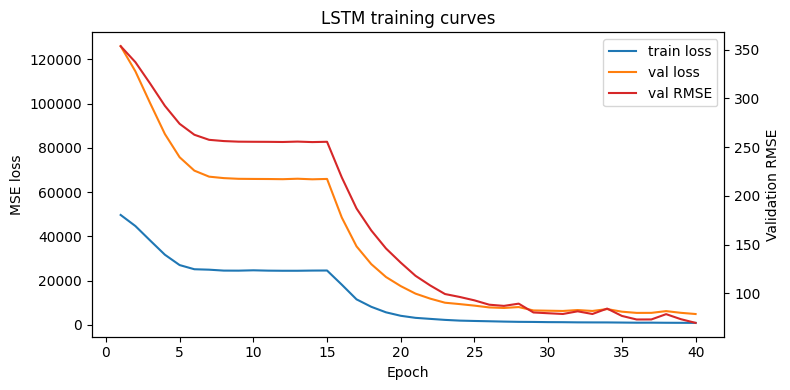

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history["epoch"], history["train_loss"], label="train loss")
ax.plot(history["epoch"], history["val_loss"], label="val loss")
ax2 = ax.twinx()
ax2.plot(history["epoch"], history["val_rmse"], color="tab:red", label="val RMSE")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax2.set_ylabel("Validation RMSE")
ax.set_title("LSTM training curves")
(lines1, labels1) = ax.get_legend_handles_labels()
(lines2, labels2) = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

save_plot(fig, "lstm_train_curves.png")

## Validation RMSE Table

In [6]:
val_table = history[["epoch", "val_rmse", "val_mae"]].tail(10).reset_index(drop=True)
val_table.style.format({"val_rmse": "{:.2f}", "val_mae": "{:.2f}"})

,epoch,val_rmse,val_mae
0,31,78.63,47.37
1,32,81.37,49.75
2,33,78.61,47.90
3,34,84.17,51.37
4,35,76.63,47.22
5,36,72.97,45.24
6,37,73.02,45.48
7,38,78.45,48.65
8,39,73.29,44.94
9,40,69.48,42.55


## Evaluation Metrics

In [7]:
metrics_path = Path(lstm_run["metrics_path"])
metrics_payload = json.loads(metrics_path.read_text())
print(f"Device used: {metrics_payload['device']}")

eval_df = pd.DataFrame(
    [metrics_payload["best_val"], metrics_payload["test"]],
    index=["validation", "test"],
)

eval_df

Device used: cpu


,rmse,mae
validation,69.479897,42.551109
test,64.506548,40.342983


## Resource Requirements
- Default configuration runs comfortably on CPU (~4-5 minutes for 40 epochs on a modern laptop) using the PyTorch CPU wheels installed above.
- Set `use_gpu=True` in `run_experiment` if a CUDA-capable device is available; training time then drops to seconds, but ensure matching CUDA wheels are installed.
- Memory footprint stays under ~2GB thanks to batching (`batch_size=256`, `seq_len=48`); monitor VRAM if enabling GPU acceleration.